In [1]:
import os
import pandas as pd
from natsort import natsorted
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from tifffile import imread
from umap import UMAP
import hdbscan
from joblib import Memory
from matplotlib.lines import Line2D

In [2]:
core = '1'

In [3]:
save_dir = '/Users/greg/Dropbox (HMS)/Baker_QC_2021/script_output/dropout'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

markers = pd.read_csv('/Volumes/My Book/cylinter_input/emit22_full/markers.csv')

include = [
    i for i in list(markers['marker_name']) if not
    any(x in i for x in ['DNA', 'IgG', 'CD56', 'CD13', 'pAUR',
        'CCNE', 'CDKN2A', 'PCNA_1', 'CDKN1B_2'])
        ]

# read unfiltered EMIT22 single-cell data
data = pd.read_parquet('/Volumes/My Book/cylinter_input/emit22_full/output/checkpoints/areaFilter.parquet')
core_data = data[data['Sample'] == core]

# isolate 'Sample' and Hoechst channel columns
dna_data = core_data[['Sample'] + [i for i in core_data.columns if 'DNA' in i]]

# isolate antibodies of interest for early cycles and total cycles
cldata_full = core_data[[i for i in core_data.columns if i in include]]
cldata_full = np.log10(cldata_full)


last_three_cycles = ['PCNA_2', 'CDK2', 'CDKN2A', 'pCREB', 'CCNB1', 'CCNE', 'CCND1', 'cPARP', 'CDKN1B_2']
cldata_early = core_data[[i for i in core_data.columns if i in include if i not in last_three_cycles]]
cldata_early = np.log10(cldata_early)

In [4]:
# save dna image from each cycle
cycle_dir = os.path.join(save_dir, 'cycle_images')
if not os.path.exists(cycle_dir):
    os.makedirs(cycle_dir)

for e, dna in enumerate([0, 4, 8, 12, 16, 20, 24, 28, 32, 36]):

    fig, ax = plt.subplots()

    # read dna image
    img = imread(f'/Volumes/My Book/cylinter_input/emit22_full/tif/{core}.ome.tif', key=dna)
    img = np.clip(img, 0, 8000) 
    plt.imshow(img, cmap='Greys')
    ax.axis('off')
    plt.tight_layout()
    plt.savefig(
        os.path.join(
            cycle_dir,
            f'dna_cycle{e+1}.png'), dpi=600
            )
    plt.close('all')

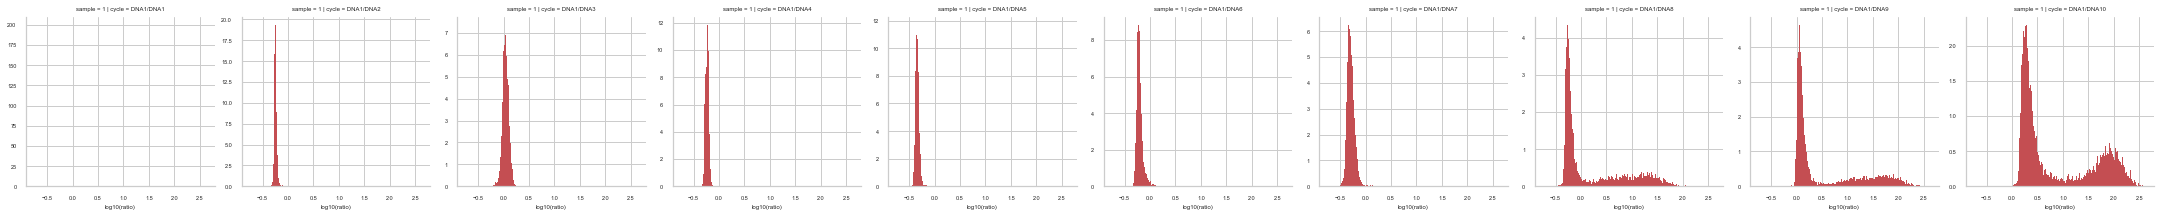

In [5]:
# plot log(ratio) histograms
dna_cycles = natsorted([i for i in dna_data.columns if 'DNA' in i])

ratios = pd.DataFrame(
    [np.log10(
        (dna_data['DNA1'] + 0.00001) /
        (dna_data[i] + 0.00001)) for i in dna_cycles]).T

list1 = [i for i in ratios.columns if i.startswith('Unnamed')]
list2 = [f'DNA1/{i}' for i in [j for j in dna_cycles[1:]]]

ratio_columns = dict(zip(list1, list2))
ratio_columns['DNA1'] = 'DNA1/DNA1'
ratios.rename(columns=ratio_columns, inplace=True)
ratios['sample'] = dna_data['Sample']

ratios_melt = (
    ratios
    .reset_index()
    .melt(id_vars=['sample', 'index'], var_name='cycle',
          value_name='log10(ratio)')
    )

ratios_melt['sample'] = pd.Categorical(
    ratios_melt['sample'], ordered=True,
    categories=natsorted(
        ratios_melt['sample'].unique()))

ratios_melt['cycle'] = pd.Categorical(
    ratios_melt['cycle'], ordered=True,
    categories=natsorted(
        ratios_melt['cycle'].unique()))

ratios_melt = (
    ratios_melt.sort_values(['sample', 'cycle', 'index'])
    )

sns.set(font_scale=0.5)
sns.set_style('whitegrid')

g = sns.FacetGrid(
    ratios_melt, row='sample',
    col='cycle', sharey=False
    )

g = g.map(
    plt.hist, 'log10(ratio)', color='r', histtype='stepfilled',
    ec='none', range=None, bins=200, density=True
    )

plt.savefig(
    os.path.join(save_dir, 'cycle_correlation_logRatios.pdf')
    )
plt.show()
plt.close('all')

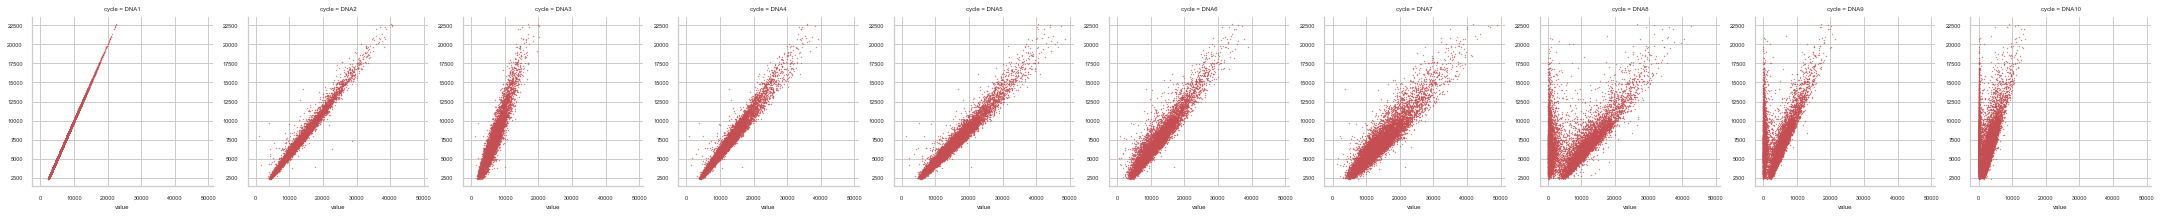

In [6]:
# plot cycle scatter points BEFORE removing dropout
facet_per_cycle_melt = (
    dna_data
    .sample(frac=1.0)
    .reset_index()
    .melt(id_vars=['Sample', 'index'], var_name='cycle',
          )
    )

facet_per_cycle_melt['Sample'] = pd.Categorical(
    facet_per_cycle_melt['Sample'], ordered=True,
    categories=natsorted(
        facet_per_cycle_melt['Sample'].unique()))

facet_per_cycle_melt['cycle'] = pd.Categorical(
    facet_per_cycle_melt['cycle'], ordered=True,
    categories=natsorted(
        facet_per_cycle_melt['cycle'].unique()))

facet_per_cycle_melt = (
    facet_per_cycle_melt.sort_values(['Sample', 'cycle', 'index'])
    )

# plot dna intensity correlation per cycle
g = sns.FacetGrid(
    facet_per_cycle_melt, col='cycle', col_wrap=10,
    sharex=True, sharey=False, aspect = 1.0
    )

g.map(
    lambda y, color: plt.scatter(
        y, facet_per_cycle_melt['value'].loc[
            facet_per_cycle_melt['cycle']
            == 'DNA1'],
        s=0.1, alpha=1.0, linewidth=None,
        marker='o', c='r'), 'value')

plt.savefig(
    os.path.join(
        save_dir, 'cycle_correlation_before.pdf')
        )
plt.show()
plt.close('all')

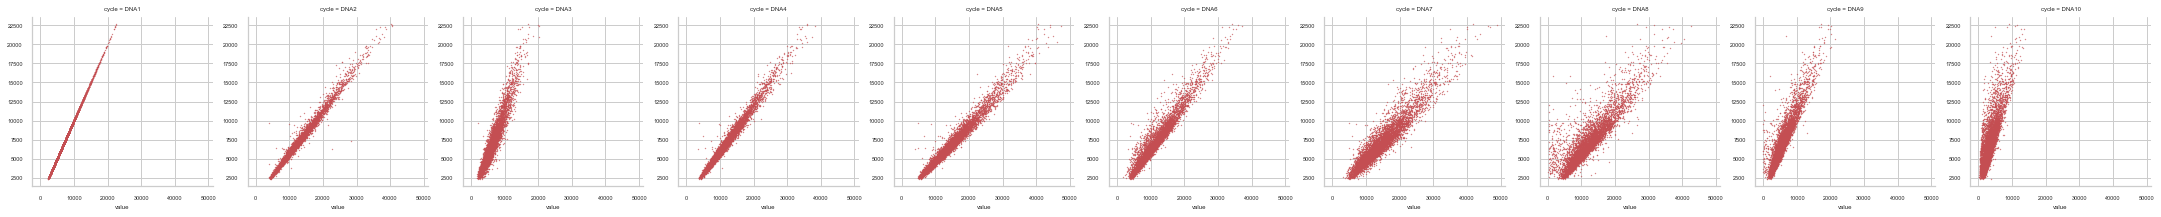

In [7]:
# plot cycle scatter points AFTER removing dropout
dna_filtered = dna_data.copy()
dna_filtered['ratio'] = np.log10(dna_filtered['DNA1']/dna_filtered['DNA10'])

# select ratio cutoff value
dna_filtered = dna_filtered[dna_filtered['ratio'] < 1.0]
dna_filtered.drop(columns='ratio', inplace=True)

facet_per_cycle_melt = (
    dna_filtered
    .sample(frac=1.0)
    .reset_index()
    .melt(id_vars=['Sample', 'index'], var_name='cycle',
          )
    )

facet_per_cycle_melt['Sample'] = pd.Categorical(
    facet_per_cycle_melt['Sample'], ordered=True,
    categories=natsorted(
        facet_per_cycle_melt['Sample'].unique()))

facet_per_cycle_melt['cycle'] = pd.Categorical(
    facet_per_cycle_melt['cycle'], ordered=True,
    categories=natsorted(
        facet_per_cycle_melt['cycle'].unique()))

facet_per_cycle_melt = (
    facet_per_cycle_melt.sort_values(['Sample', 'cycle', 'index'])
    )

g = sns.FacetGrid(
    facet_per_cycle_melt, col='cycle', col_wrap=10,
    sharex=True, sharey=False
    )

g.map(
    lambda y, color: plt.scatter(
        y, facet_per_cycle_melt['value'].loc[
            facet_per_cycle_melt['cycle']
            == 'DNA1'],
        s=0.1, alpha=1.0, linewidth=None,
        marker='o', c='r'), 'value')
plt.savefig(
    os.path.join(
        save_dir, 'cycle_correlation_after.pdf')
        )
plt.show()
plt.close('all')

9358


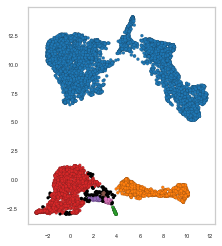

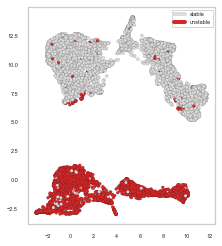

In [8]:
embedding = UMAP(random_state=5).fit_transform(cldata_full)
cldata_full['emb1'] = embedding[:, 0]
cldata_full['emb2'] = embedding[:, 1]

clustering_full = hdbscan.HDBSCAN(min_cluster_size=22).fit(
        cldata_full[['emb1', 'emb2']]
        )
cldata_full['cluster'] = clustering_full.labels_

# color embedding by cluster
colors = {-1: '#000000', 0: '#1f77b4', 1: '#ff7f0e', 2: '#2ca02c',
          3: '#d62728', 4: '#9467bd', 5: '#8c564b', 6: '#e377c2',
          7: '#7f7f7f', 8: '#bcbd22', 9: '#17becf'}
cldata_full['color_cluster'] = [colors[i] for i in cldata_full['cluster']]

print(len(cldata_full))

fig, ax = plt.subplots()
ax.scatter(cldata_full['emb1'], cldata_full['emb2'], c=cldata_full['color_cluster'], s=9.5, ec='k', lw=0.1, alpha=1.0)
ax.set_aspect('equal')
plt.grid(False)
plt.savefig(
    os.path.join(
        save_dir, 'clustering_by_cluster.pdf')
        )
plt.show()
plt.close('all')

stable_idx = dna_filtered.index
cldata_full['color_stability'] = ['gainsboro' if i in stable_idx else 'tab:red' for i in cldata_full.index]
cldata_full['lw'] = [0.1 if i in stable_idx else 0.1 for i in cldata_full.index]

# color embedding by stability
fig, ax = plt.subplots()
ax.scatter(cldata_full['emb1'], cldata_full['emb2'], c=cldata_full['color_stability'], s=9.5, ec='k', lw=cldata_full['lw'], alpha=1.0)
ax.set_aspect('equal')
plt.grid(False)

custom_lines = [(Line2D([0], [0], color='gainsboro', lw=4)), (Line2D([0], [0], color='tab:red', lw=4))]
plt.legend(custom_lines, ['stable', 'unstable'])
plt.savefig(
    os.path.join(
        save_dir, 'clustering_by_stability.pdf')
        )
plt.show()
plt.close('all')

In [9]:
embedding = UMAP(random_state=5).fit_transform(cldata_early)
cldata_early['emb1'] = embedding[:, 0]
cldata_early['emb2'] = embedding[:, 1]

clustering_early = hdbscan.HDBSCAN(min_cluster_size=15).fit(
        cldata_early[['emb1', 'emb2']]
        )
cldata_early['cluster'] = clustering_early.labels_

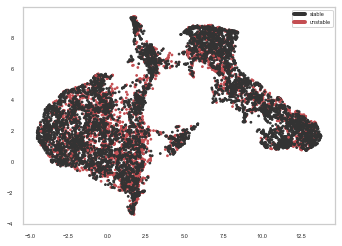

In [10]:
colors = {-1: '#000000', 0: '#1f77b4', 1: '#ff7f0e', 2: '#2ca02c',
          3: '#d62728', 4: '#9467bd', 5: '#8c564b', 6: '#e377c2',
          7: '#7f7f7f', 8: '#bcbd22', 9: '#17becf'}
cldata_early['color_cluster'] = [colors[i] for i in cldata_early['cluster']]

stable_idx = dna_filtered.index
cldata_early['color_stability'] = [
    '#333333' if i in stable_idx else '#c44e52'
    for i in cldata_early.index]

# color embedding by cluster
fig, ax = plt.subplots()
ax.scatter(cldata_early['emb1'], cldata_early['emb2'], c=cldata_early['color_cluster'], s=9.5, ec='k', alpha=1.0)
ax.set_aspect('equal')
plt.grid(False)
plt.savefig(
    os.path.join(
        save_dir, 'clustering_by_cluster_early.pdf')
        )
plt.close('all')

# color embedding by stability
fig, ax = plt.subplots()
ax.scatter(cldata_early['emb1'], cldata_early['emb2'], c=cldata_early['color_stability'], s=3.0)
ax.set_aspect('equal')
plt.grid(False)

custom_lines = [Line2D([0], [0], color='#333333', lw=4),
                Line2D([0], [0], color='#c44e52', lw=4),
                ]
plt.legend(custom_lines, ['stable', 'unstable'])
plt.savefig(
    os.path.join(
        save_dir, 'clustering_by_stability_early.pdf')
        )
plt.show()
plt.close('all')